In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [2]:
round_num = 10
font = 14

def readfile(pred_data):
    data = pd.read_csv(pred_data).T.to_numpy()
    f1 = np.array([f1_score(data[0], data[i],average=None) for i in range(1,round_num+1)]).T
    f1_macro = np.array([f1_score(data[0], data[i],average='macro') for i in range(1,round_num+1)]).T
    precision = np.array([precision_score(data[0], data[i],average=None) for i in range(1,round_num+1)]).T
    recall = np.array([recall_score(data[0], data[i],average=None) for i in range(1,round_num+1)]).T
    accuracy = np.array([accuracy_score(data[0], data[i]) for i in range(1,round_num+1)])
    return f1, precision, recall, accuracy, f1_macro
 

def getxy(root_dir, files, poscode=1, repeat_time=3):
    x = []
    y = []
    for f in np.sort(files):
        f1 = np.zeros((3,round_num))
        precision = np.zeros((3,round_num))
        recall = np.zeros((3,round_num))
        accuracy = np.zeros(round_num)
        # print(f.split('_')[2])
        x.append(float(f.split('_')[2].split('-')[poscode]))
        for n in range(repeat_time):
            pred_data = f'{root_dir}/{f}_{n}.csv'
            a,b,c,d,f_ = readfile(pred_data)
            f1 += a
            precision += b
            recall += c
            accuracy += d
        f1 /= repeat_time
        precision /= repeat_time
        recall /= repeat_time
        accuracy /= repeat_time
        y.append(np.mean(f1, axis=0)[[-1]])
        # plotfile(f, f1, precision, recall, accuracy, f1_macro)
    return x, y


def metrics_from_txt(fname, repeat_time=3):
    paragraph = []
    count = 0
    with open(fname) as f:
        for sentence in f.readlines():
            # print(sentence)
            if sentence.startswith('Round'):
                # print(sentence[:-1])
                if sentence == 'Round 0:\n':
                    paragraph.append(sentence[:-2])
                else:
                    paragraph.append(sentence[:-2])
            elif sentence.startswith('testing '):
                # print(sentence[:-1])
                paragraph.append(sentence[:-1])
            elif sentence.startswith('!!!!!total used time:'):
                time = float(sentence.split(' ')[-1])
            elif sentence.startswith('sum of update iteration: '):
                count += int(sentence.split(' ')[-1])
    # print(paragraph)
    data_dict = {}
    for n in range(len(paragraph)//3):
        roundnum = paragraph[3*n].split()[1]
        acc = paragraph[3*n+1].split()
        f1 = paragraph[3*n+2].split()
        if int(roundnum) not in data_dict:
            data_dict[int(roundnum)] = {acc[1]:[float(acc[2])], f1[1]:[float(f1[2])]}
        elif int(roundnum) in data_dict:
            data_dict[int(roundnum)][acc[1]].append(float(acc[2]))
            data_dict[int(roundnum)][f1[1]].append(float(f1[2]))
    for n in range(11):
        data_dict[n]['accuracy'] = np.mean(data_dict[n]['accuracy'])
        data_dict[n]['F1'] = np.mean(data_dict[n]['F1'])
    df = pd.DataFrame.from_dict(data_dict).T
    # print(df)
    return df, time, count


def plotfile(f, f1, precision, recall, accuracy, f1_marco):
    x = [x*10 for x in range(round_num)]
    fig, ax = plt.subplots(1,3, figsize=(15,4.5))
    [ax[0].plot(x, f1[i], label=f'label{i}') for i in range(3)]
    [ax[1].plot(x, precision[i], label=f'label{i}') for i in range(3)]
    [ax[2].plot(x, recall[i], label=f'label{i}') for i in range(3)]
    ax[0].set_ylabel('f1', size=font)
    ax[1].set_ylabel('precision', size=font)
    ax[2].set_ylabel('recall', size=font)
    [ax[i].set_xlabel('Number of Finetunning Samples', size=font) for i in range(3)]
    plt.legend(bbox_to_anchor=(1.3, 0.6))
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

    fig, ax = plt.subplots(1,5, figsize=(25,5))
    ax[0].plot(x, accuracy, label='accuracy')
    ax[0].set_ylabel('accuracy', size=font)
    ax[1].plot(x, np.mean(f1, axis=0), label='f1')
    ax[1].set_ylabel('f1', size=font)
    ax[2].plot(x, np.mean(precision, axis=0), label='precision')
    ax[2].set_ylabel('precision', size=font)
    ax[3].plot(x, np.mean(recall, axis=0), label='recall')
    ax[3].set_ylabel('recall', size=font)
    ax[4].plot(x, f1_marco, label='f1_macro')
    ax[4].set_ylabel('f1_macro', size=font)
    # [ax[i].set_xlabel(':Number of Finetunning Samples', size=font) for i in range(4)]
    ax[1].set_xlabel(f'{f}:Number of Finetunning Samples', size=font)
    # plt.legend(bbox_to_anchor=(1.0, 0.6))
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

# Ratio

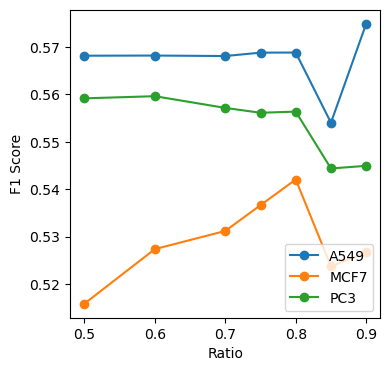

In [3]:
logroot = '/egr/research-aidd/menghan1/AnchorDrug/ActiveLearning_one_cellline/logfile/advbim_ratio/'
root_dir = '/egr/research-aidd/menghan1/AnchorDrug/ActiveLearning_one_cellline/preds/advbim_ratio'
file_list = os.listdir(logroot)
file_list_A549 = [f[:-4] for f in file_list if 'A549_AdversarialBIM' in f]
file_list_MCF7 = [f[:-4]  for f in file_list if 'MCF7_AdversarialBIM' in f]
file_list_PC3 = [f[:-4]  for f in file_list if 'PC3_AdversarialBIM' in f]

xa549, ya549 = getxy(root_dir, file_list_A549, poscode=1)
xpc3, ypc3 = getxy(root_dir, file_list_PC3, poscode=1)
xmcf7, ymcf7 = getxy(root_dir, file_list_MCF7, poscode=1)

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(xa549, ya549, 'o-', label='A549')
ax.plot(xmcf7, ymcf7, 'o-', label='MCF7')
ax.plot(xpc3, ypc3, 'o-', label='PC3')
plt.legend(loc='lower right')
plt.ylabel('F1 Score')
plt.xlabel('Ratio')
plt.show()

# distance

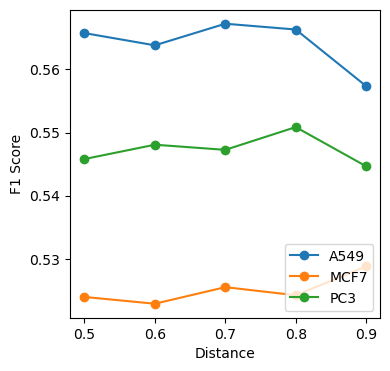

In [6]:
logroot = '/egr/research-aidd/menghan1/AnchorDrug/ActiveLearning_one_cellline/logfile/advbim_dist/'
root_dir = '/egr/research-aidd/menghan1/AnchorDrug/ActiveLearning_one_cellline/preds/advbim_dist'
file_list = os.listdir(logroot)
file_list_A549 = [f[:-4] for f in file_list if 'A549_AdversarialBIM' in f]
file_list_MCF7 = [f[:-4]  for f in file_list if 'MCF7_AdversarialBIM' in f]
file_list_PC3 = [f[:-4]  for f in file_list if 'PC3_AdversarialBIM' in f]

xa549, ya549 = getxy(root_dir, file_list_A549, poscode=2)
xpc3, ypc3 = getxy(root_dir, file_list_PC3, poscode=2)
xmcf7, ymcf7 = getxy(root_dir, file_list_MCF7, poscode=2)

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(xa549, ya549, 'o-', label='A549')
ax.plot(xmcf7, ymcf7, 'o-', label='MCF7')
ax.plot(xpc3, ypc3, 'o-', label='PC3')
plt.legend(loc='lower right')
plt.ylabel('F1 Score')
plt.xlabel('Distance')
# plt.title('')
plt.show()

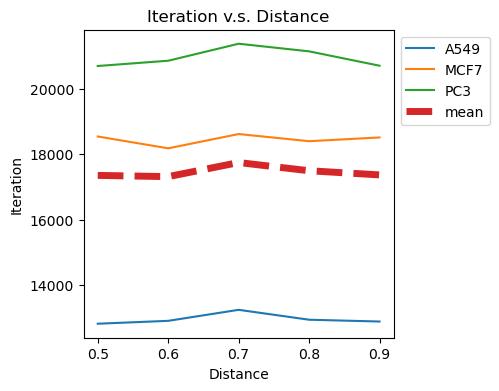

In [15]:
file_dir = '/egr/research-aidd/menghan1/AnchorDrug/ActiveLearning_one_cellline/logfile/advbim_dist/'
file_list = os.listdir(file_dir)
repeat = 3

fig1, ax1 = plt.subplots(1,1, figsize=(4,4))
count_mean = [0,0,0,0,0]
for c in ['A549', 'MCF7', 'PC3']:
    file_list_c = [f for f in file_list if f'{c}_AdversarialBIM' in f]
    # fig, ax = plt.subplots(1,2, figsize=(10,4))
    dist_list = []
    time_list = []
    count_list = []
    for f in np.sort(file_list_c):
        # print(f)
        dist_list.append(float(f.split('_')[2].split('-')[2]))
        df, time, count = metrics_from_txt(f'{file_dir}/{f}')
        time_list.append(time/repeat)
        count_list.append(count/repeat)
        x = df.index.to_list()
        # acc = df.accuracy.to_list()
        # f1 = df.F1.to_list()
    #     ax[0].plot(x, acc, label=f.split('-')[2].split('_')[0])
    #     ax[1].plot(x, f1, label=f.split('-')[2].split('_')[0])
    # plt.legend(bbox_to_anchor=(1.1, 1.05))
    # ax[0].set_title(f'Cell line {c}: Accuracy')
    # ax[1].set_title(f'Cell line {c}: F1-score')
    # fig.tight_layout()  # otherwise the right y-label is slightly clipped
    # plt.show()
    count_mean = [sum(x) for x in zip(count_mean, count_list)]
    ax1.plot(dist_list, count_list, label=c)
    
ax1.plot(dist_list, [e/3 for e in count_mean], '--', label='mean', linewidth=5.0)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Iteration')
plt.xlabel('Distance')
plt.title('Iteration v.s. Distance')
plt.show()

# EPS

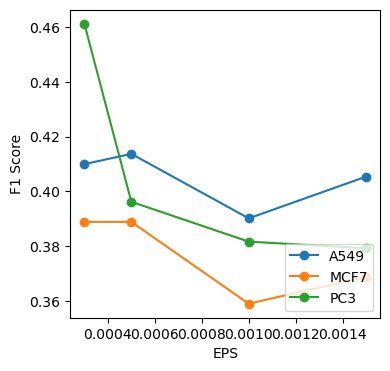

In [12]:
file_list = os.listdir('/egr/research-aidd/menghan1/AnchorDrug/ActiveLearning_one_cellline/logfile/advbim_eps/')
file_list_A549 = [f[:-4] for f in file_list if 'A549_AdversarialBIM' in f]
file_list_MCF7 = [f[:-4]  for f in file_list if 'MCF7_AdversarialBIM' in f]
file_list_PC3 = [f[:-4]  for f in file_list if 'PC3_AdversarialBIM' in f]
root_dir = '/egr/research-aidd/menghan1/AnchorDrug/ActiveLearning_one_cellline/preds/advbim_eps'
   
xa549, ya549 = getxy(root_dir, file_list_A549, poscode=1)
xpc3, ypc3 = getxy(root_dir, file_list_PC3, poscode=1)
xmcf7, ymcf7 = getxy(root_dir, file_list_MCF7, poscode=1)

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(xa549, ya549, 'o-', label='A549')
ax.plot(xmcf7, ymcf7, 'o-', label='MCF7')
ax.plot(xpc3, ypc3, 'o-', label='PC3')
plt.legend(loc='lower right')
plt.ylabel('F1 Score')
plt.xlabel('EPS')
# plt.title('')
plt.show()

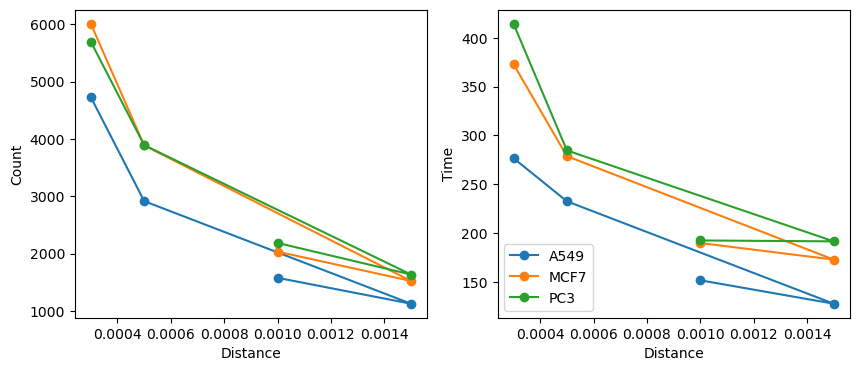

In [13]:
file_dir = '/egr/research-aidd/menghan1/AnchorDrug/ActiveLearning_one_cellline/logfile/advbim_eps/'
file_list = os.listdir(file_dir)

fig1, ax = plt.subplots(1,2, figsize=(10,4))
for c in ['A549', 'MCF7', 'PC3']:
    file_list_c = [f for f in file_list if f'{c}_AdversarialBIM' in f]
    # fig, ax = plt.subplots(1,2, figsize=(10,4))
    dist_list = []
    time_list = []
    count_list = []
    for f in np.sort(file_list_c):
        # print(f)
        dist_list.append(float(f.split('-')[3].split('_')[0]))
        df, time, count = metrics_from_txt(f'{file_dir}/{f}')
        time_list.append(time/5)
        count_list.append(count/50)
        x = df.index.to_list()
        acc = df.accuracy.to_list()
        f1 = df.F1.to_list()
    #     ax[0].plot(x, acc, label=f.split('-')[2].split('_')[0])
    #     ax[1].plot(x, f1, label=f.split('-')[2].split('_')[0])
    # plt.legend(bbox_to_anchor=(1.1, 1.05))
    # ax[0].set_title(f'Cell line {c}: Accuracy')
    # ax[1].set_title(f'Cell line {c}: F1-score')
    # fig.tight_layout()  # otherwise the right y-label is slightly clipped
    # plt.show()
    
    ax[1].plot(dist_list, time_list, 'o-', label=c)
    ax[0].plot(dist_list, count_list, 'o-', label=c)
    plt.legend(loc='lower left')


ax[1].set_ylabel('Time')
ax[0].set_ylabel('Count')
ax[1].set_xlabel('Distance')
ax[0].set_xlabel('Distance')
fig.tight_layout()
plt.show()